# Type 2 Diabetes Detection from Microbiome Data

This notebook builds a course-aligned preprocessing workflow for microbiome data and demonstrates how to move from raw abundance tables to model-ready representations.

### Goals
- Inspect raw data structure and sparsity.
- Apply **MIPMLP-inspired preprocessing** (prevalence filtering, log transform, subPCA by taxonomy groups).
- Visualize each preprocessing step, including **before/after log transform**.
- Show **raw shape vs post-subPCA shape**.
- Train baseline classifiers and interpret outputs with medically relevant metrics.


## Workflow Roadmap

1. Load data and define target labels.
2. Explore raw microbiome characteristics (composition, sparsity, prevalence).
3. Build preprocessing tools (prevalence filter + MIPMLP subPCA).
4. Apply leakage-safe preprocessing (fit on train only, transform test).
5. Compare representations with visualization and baseline models.

All code cells are written to be copy-ready for the Methods section of the project report.


In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

from IPython.display import display

SEED = 42
np.random.seed(SEED)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)


## 1. Load Data and Define Prediction Target

We keep the full multiclass label (`healthy`, `IGT`, `T2D`) for descriptive analysis.
For baseline modeling, we start with a clinically practical binary target:

- `1`: T2D
- `0`: non-T2D (`healthy` + `IGT`)

This can later be extended to multiclass modeling.


In [8]:
DATA_PATH = "T2D_microbiome_dataset.csv"

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c != "label"]

X_raw = df[feature_cols].copy()
y_multiclass = df["label"].copy()
y_binary = (y_multiclass == "T2D").astype(int)

print(f"Raw data shape (samples, features): {X_raw.shape}")
print("\nMulticlass label counts:")
display(y_multiclass.value_counts().rename_axis("label").to_frame("count"))

print("Preview of first 3 samples:")
display(df.head(3))


Raw data shape (samples, features): (145, 498)

Multiclass label counts:


,count
label,
T2D,53
IGT,49
healthy,43


Preview of first 3 samples:


,species:Faecalibacterium prausnitzii,species:Dorea longicatena,species:Fusicatenibacter saccharivorans,species:Blautia obeum,species:Coprococcus comes,species:Bacteroides uniformis,species:Collinsella aerofaciens,species:Bifidobacterium adolescentis,species:[Ruminococcus] torques,species:[Eubacterium] rectale,...,species:Raoultella ornithinolytica,species:Kluyvera cryocrescens,species:Raoultella planticola,species:Kluyvera ascorbata,species:Lactococcus raffinolactis,species:Prevotella sp. 885,species:Anaeromassilibacillus sp. An172,species:Corynebacterium glutamicum,species:Subdoligranulum variabile,label
0,16.77088,8.86025,7.79429,7.34667,6.47102,5.74062,5.61847,4.15568,4.08278,2.49154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IGT
1,4.68705,2.68031,1.37876,0.26129,0.27289,1.73862,0.27524,0.48050,0.24181,0.58563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,healthy
2,12.09206,3.05321,3.40659,0.26809,1.17859,1.69510,2.11810,2.41923,0.92541,0.00454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,healthy


### How to read this output

- `shape`: number of patient samples and taxa features.
- `label counts`: class balance; this affects train/test split strategy and evaluation metrics.
- Preview confirms taxonomy-like column naming (`species:...`, `genus:...`) and a final `label` column.


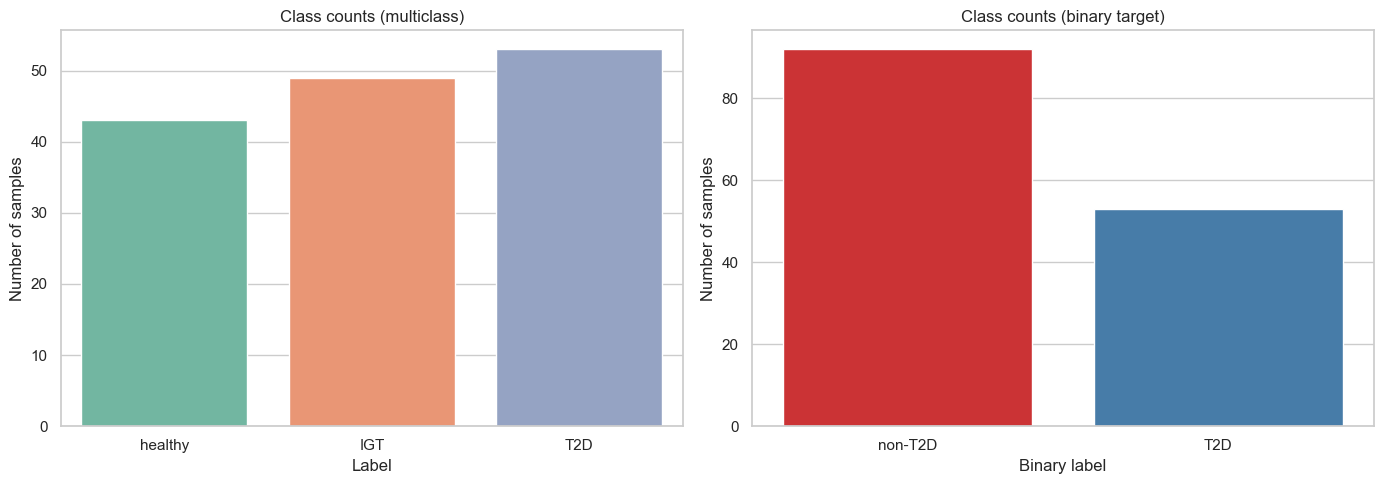

In [9]:
label_order = ["healthy", "IGT", "T2D"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_multiclass, order=label_order, palette="Set2", ax=axes[0])
axes[0].set_title("Class counts (multiclass)")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Number of samples")

binary_counts = pd.Series(np.where(y_binary == 1, "T2D", "non-T2D")).value_counts()
sns.barplot(x=binary_counts.index, y=binary_counts.values, palette="Set1", ax=axes[1])
axes[1].set_title("Class counts (binary target)")
axes[1].set_xlabel("Binary label")
axes[1].set_ylabel("Number of samples")

plt.tight_layout()
plt.show()


## 2. Raw Microbiome Diagnostics

Microbiome tables are typically sparse, compositional, and high-dimensional.
We verify those assumptions before applying any transform.


Row sum min / median / max: 97.329 / 99.938 / 100.000
Global zero fraction: 0.800
Features present in <10% of samples: 289 / 498


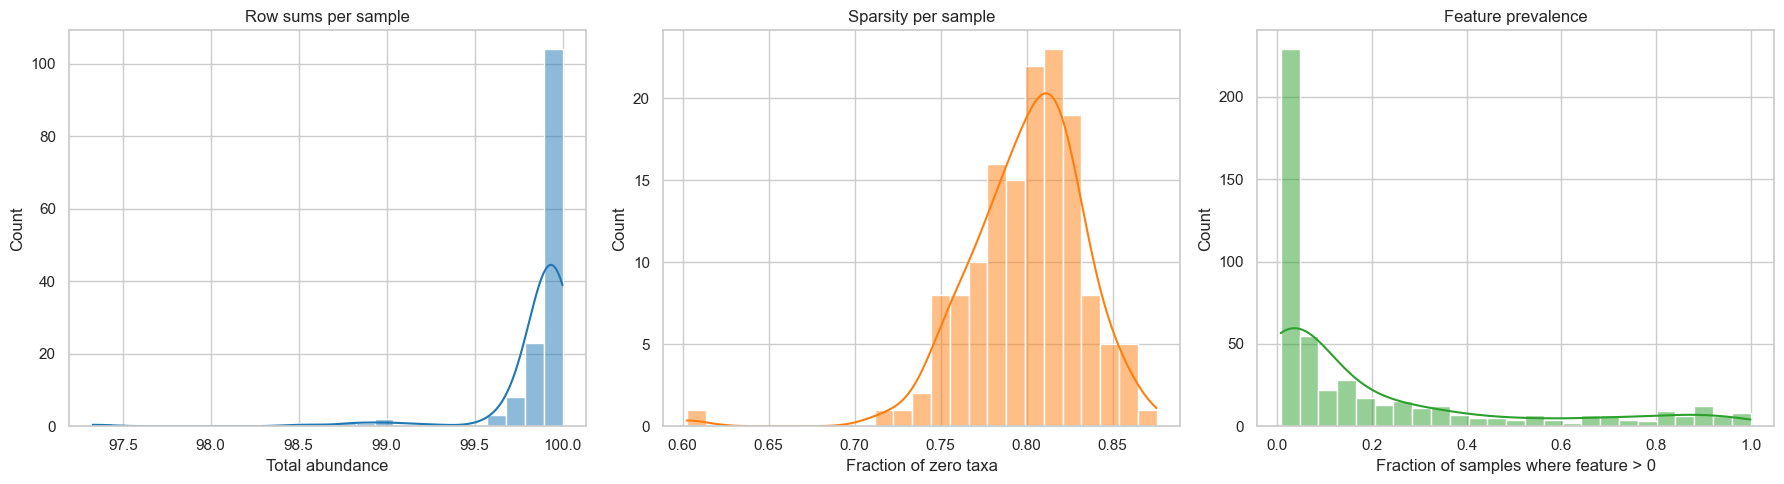

In [10]:
row_sums = X_raw.sum(axis=1)
sample_zero_fraction = (X_raw == 0).mean(axis=1)
feature_prevalence = (X_raw > 0).mean(axis=0)
feature_mean = X_raw.mean(axis=0)

print(f"Row sum min / median / max: {row_sums.min():.3f} / {row_sums.median():.3f} / {row_sums.max():.3f}")
print(f"Global zero fraction: {(X_raw == 0).mean().mean():.3f}")
print(f"Features present in <10% of samples: {(feature_prevalence < 0.10).sum()} / {X_raw.shape[1]}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(row_sums, bins=25, kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Row sums per sample")
axes[0].set_xlabel("Total abundance")

sns.histplot(sample_zero_fraction, bins=25, kde=True, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Sparsity per sample")
axes[1].set_xlabel("Fraction of zero taxa")

sns.histplot(feature_prevalence, bins=25, kde=True, ax=axes[2], color="#2ca02c")
axes[2].set_title("Feature prevalence")
axes[2].set_xlabel("Fraction of samples where feature > 0")

plt.tight_layout()
plt.show()


### Interpretation notes

- Row sums close to the same value suggest relative abundance-style data.
- High zero fraction supports using prevalence filtering before modeling.
- Prevalence histogram helps choose a threshold (here we use `>=10%` in train set).


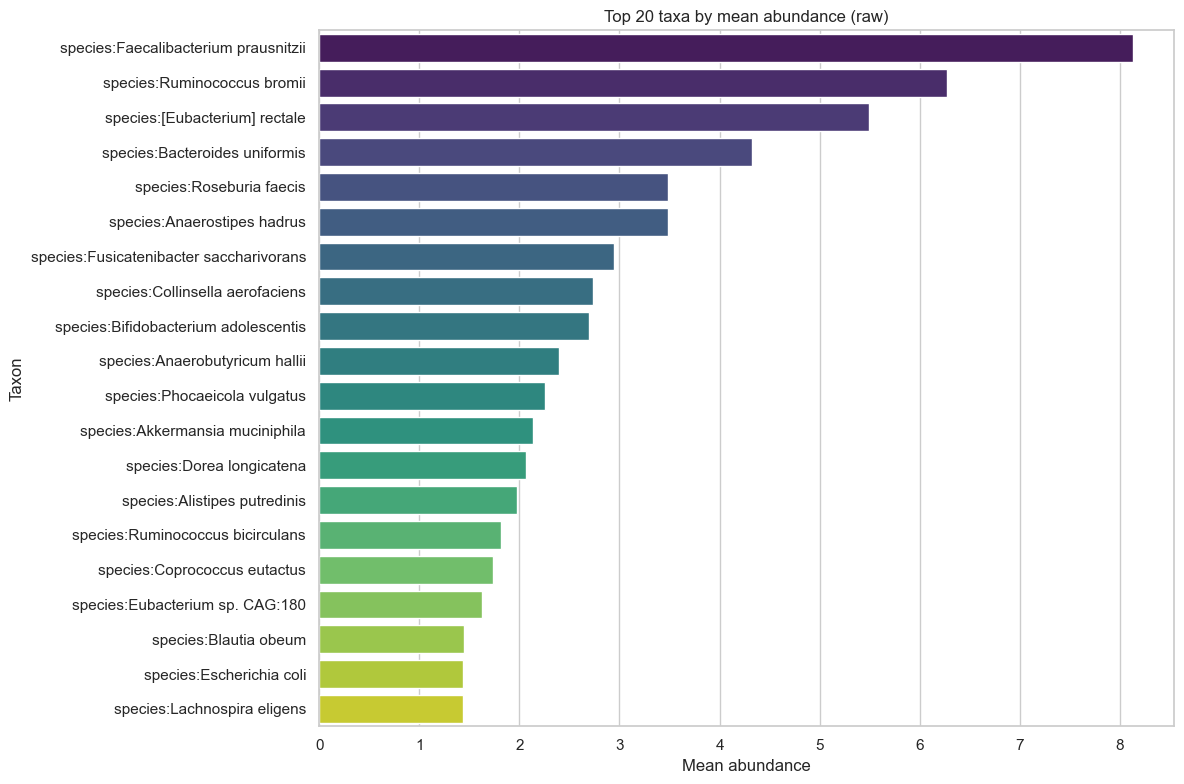

In [11]:
top_taxa = feature_mean.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_taxa.values, y=top_taxa.index, palette="viridis")
plt.title("Top 20 taxa by mean abundance (raw)")
plt.xlabel("Mean abundance")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()


## 3. MIPMLP-Inspired Preprocessing Utilities

From the lecture pipeline, we implement:

- **Prevalence filter**: remove very rare taxa.
- **Log transform (`log1p`)**: stabilize skew and compress heavy tails.
- **SubPCA by taxonomy group**: for each genus-like group, summarize multiple related taxa by PC1.

Important: these steps are fit on the training set only, then applied to test set (no leakage).

In [22]:
def extract_genus(feature_name: str) -> str:
    if feature_name.startswith("genus:"):
        return feature_name.split(":", 1)[1].strip()
    if feature_name.startswith("species:"):
        species_name = feature_name.split(":", 1)[1].strip()
        first_token = species_name.split()[0] if species_name else "unknown"
        return first_token.strip("[]")
    return feature_name.split(":", 1)[0]


class PrevalenceFilter:
    def __init__(self, min_prevalence: float = 0.10):
        self.min_prevalence = min_prevalence
        self.keep_cols_ = None

    def fit(self, X: pd.DataFrame):
        prevalence = (X > 0).mean(axis=0)
        self.keep_cols_ = prevalence[prevalence >= self.min_prevalence].index.tolist()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.keep_cols_ is None:
            raise RuntimeError("fit must be called before transform")
        return X.loc[:, self.keep_cols_].copy()

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return self.fit(X).transform(X)


class MIPMLPSubPCA:
    def __init__(self, min_group_size: int = 2):
        self.min_group_size = min_group_size
        self.group_models_ = {}
        self.explained_variance_ = {}

    def fit(self, X: pd.DataFrame):
        groups = {}
        for col in X.columns:
            genus = extract_genus(col)
            groups.setdefault(genus, []).append(col)

        self.group_models_ = {}
        self.explained_variance_ = {}

        for genus, cols in sorted(groups.items()):
            if len(cols) >= self.min_group_size:
                scaler = StandardScaler()
                X_group = scaler.fit_transform(X[cols])
                pca = PCA(n_components=1, random_state=SEED)
                pca.fit(X_group)

                self.group_models_[genus] = {
                    "mode": "pca",
                    "cols": cols,
                    "scaler": scaler,
                    "pca": pca,
                }
                self.explained_variance_[genus] = float(pca.explained_variance_ratio_[0])
            else:
                self.group_models_[genus] = {
                    "mode": "single",
                    "col": cols[0],
                }

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if not self.group_models_:
            raise RuntimeError("fit must be called before transform")

        transformed = {}
        for genus, model in self.group_models_.items():
            if model["mode"] == "pca":
                X_group = model["scaler"].transform(X[model["cols"]])
                transformed[f"subpca:{genus}"] = model["pca"].transform(X_group).ravel()
            else:
                col = model["col"]
                transformed[f"single:{col}"] = X[col].values

        return pd.DataFrame(transformed, index=X.index)

    def summary(self) -> pd.DataFrame:
        rows = []
        for genus, model in self.group_models_.items():
            if model["mode"] == "pca":
                rows.append(
                    {
                        "group": genus,
                        "mode": "subPCA",
                        "n_original_features": len(model["cols"]),
                        "pc1_explained_variance": self.explained_variance_[genus],
                    }
                )
            else:
                rows.append(
                    {
                        "group": genus,
                        "mode": "single",
                        "n_original_features": 1,
                        "pc1_explained_variance": np.nan,
                    }
                )
        return pd.DataFrame(rows).sort_values(["mode", "n_original_features"], ascending=[True, False])


## 4. Train/Test Split and Leakage-Safe Preprocessing

We split first, then fit preprocessing on train only:

1. Prevalence filter (`>=10%` non-zero in train).
2. `log1p` transform.
3. Z-score scaling for algorithms sensitive to feature scale.

In [24]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw,
    y_binary,
    test_size=0.20,
    stratify=y_binary,
    random_state=SEED,
)

print(f"Train raw shape: {X_train_raw.shape}")
print(f"Test raw shape:  {X_test_raw.shape}")
print(f"T2D rate train/test: {y_train.mean():.3f} / {y_test.mean():.3f}")

prevalence_filter = PrevalenceFilter(min_prevalence=0.10)
X_train_f = prevalence_filter.fit_transform(X_train_raw)
X_test_f = prevalence_filter.transform(X_test_raw)

print(f"After prevalence filter (train): {X_train_f.shape}")
print(f"After prevalence filter (test):  {X_test_f.shape}")
print(f"Removed features: {X_train_raw.shape[1] - X_train_f.shape[1]}")

X_train_log = np.log1p(X_train_f)
X_test_log = np.log1p(X_test_f)

base_scaler = StandardScaler()
X_train_base_z = pd.DataFrame(
    base_scaler.fit_transform(X_train_log),
    columns=X_train_log.columns,
    index=X_train_log.index,
)
X_test_base_z = pd.DataFrame(
    base_scaler.transform(X_test_log),
    columns=X_test_log.columns,
    index=X_test_log.index,
)


Train raw shape: (116, 498)
Test raw shape:  (29, 498)
T2D rate train/test: 0.362 / 0.379
After prevalence filter (train): (116, 209)
After prevalence filter (test):  (29, 209)
Removed features: 289


,stage,n_samples,n_features
0,Raw,145,498
1,After prevalence filter,145,209
2,After log1p,145,209


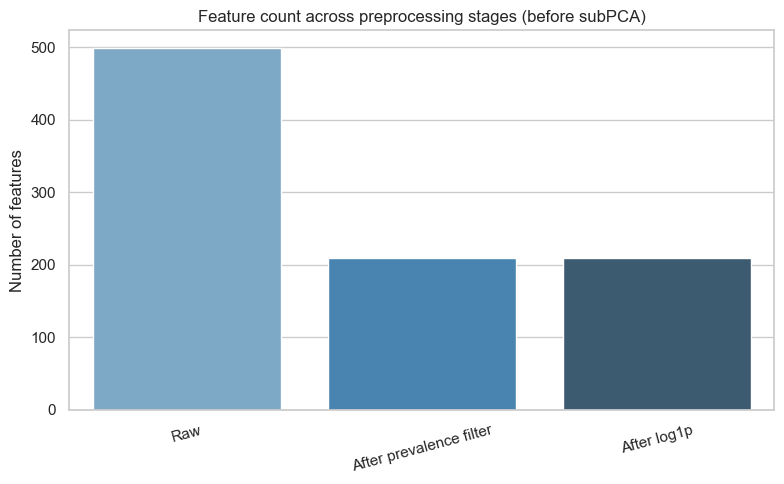

In [25]:
X_full_f = prevalence_filter.transform(X_raw)
X_full_log = np.log1p(X_full_f)

shape_table = pd.DataFrame(
    [
        {"stage": "Raw", "n_samples": X_raw.shape[0], "n_features": X_raw.shape[1]},
        {
            "stage": "After prevalence filter",
            "n_samples": X_full_f.shape[0],
            "n_features": X_full_f.shape[1],
        },
        {"stage": "After log1p", "n_samples": X_full_log.shape[0], "n_features": X_full_log.shape[1]},
    ]
)

display(shape_table)

plt.figure(figsize=(8, 5))
sns.barplot(data=shape_table, x="stage", y="n_features", palette="Blues_d")
plt.title("Feature count across preprocessing stages (before subPCA)")
plt.xlabel("")
plt.ylabel("Number of features")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## 5. Before/After Log Transform Visualizations

These plots answer: "Did log transform reduce skew and make taxa distributions easier for models to learn?"


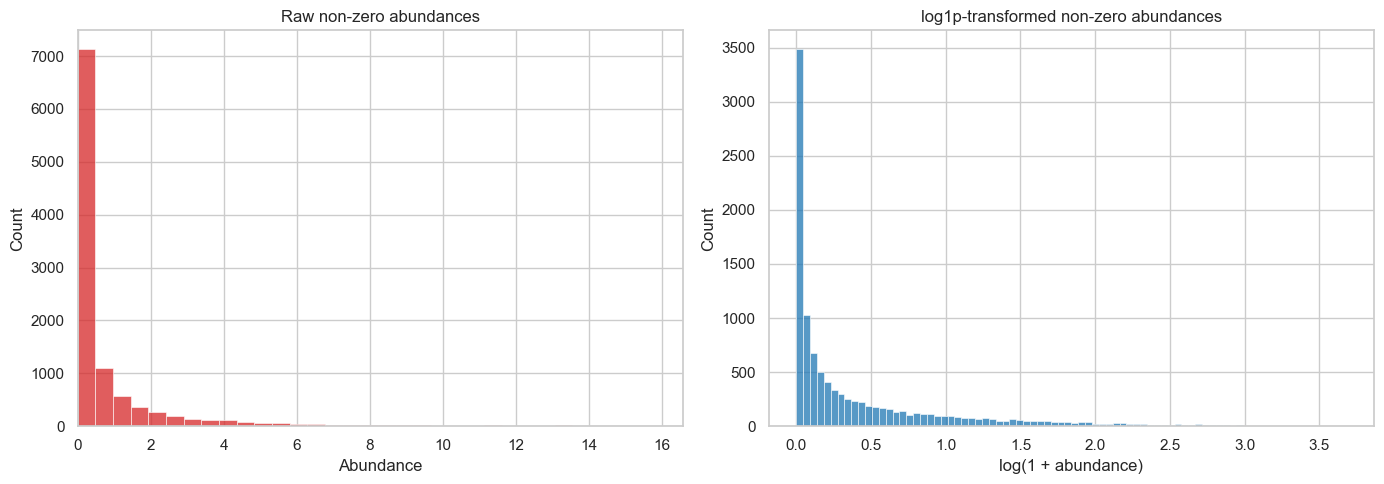

Raw mean/median ratio: 6.58
Log mean/median ratio: 2.93


In [26]:
raw_nonzero = X_train_f.values.ravel()
raw_nonzero = raw_nonzero[raw_nonzero > 0]
log_nonzero = np.log1p(raw_nonzero)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(raw_nonzero, bins=80, ax=axes[0], color="#d62728")
axes[0].set_title("Raw non-zero abundances")
axes[0].set_xlabel("Abundance")
axes[0].set_xlim(0, np.percentile(raw_nonzero, 99.5))

sns.histplot(log_nonzero, bins=80, ax=axes[1], color="#1f77b4")
axes[1].set_title("log1p-transformed non-zero abundances")
axes[1].set_xlabel("log(1 + abundance)")

plt.tight_layout()
plt.show()

print(f"Raw mean/median ratio: {raw_nonzero.mean() / np.median(raw_nonzero):.2f}")
print(f"Log mean/median ratio: {log_nonzero.mean() / np.median(log_nonzero):.2f}")


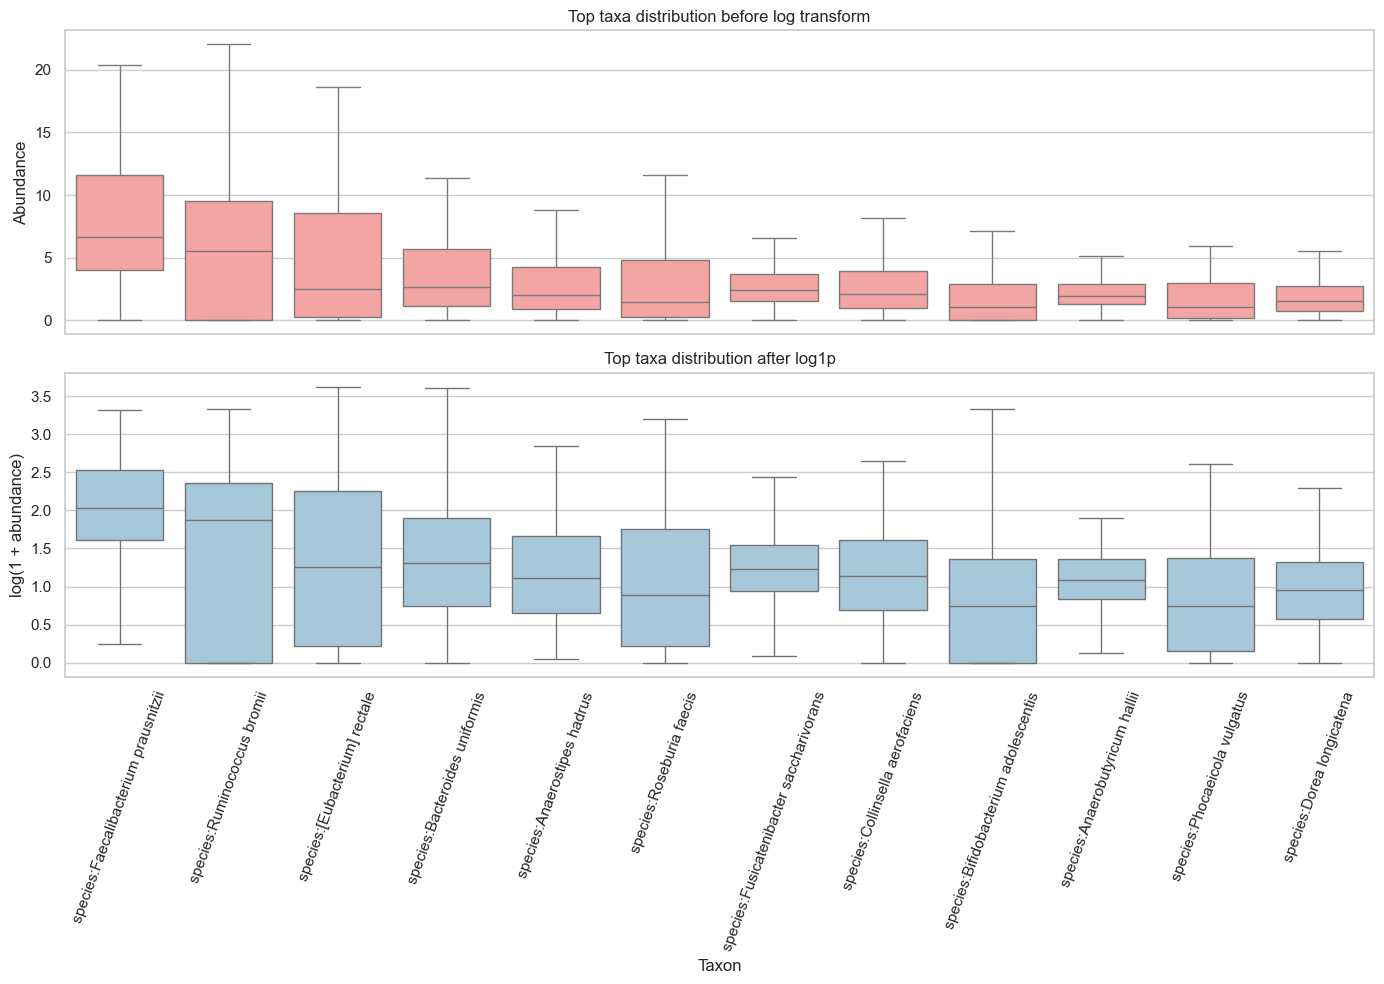

In [27]:
top12 = X_train_f.mean(axis=0).sort_values(ascending=False).head(12).index.tolist()

raw_melt = X_train_f[top12].melt(var_name="taxon", value_name="value")
raw_melt["scale"] = "raw"

log_melt = X_train_log[top12].melt(var_name="taxon", value_name="value")
log_melt["scale"] = "log1p"

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.boxplot(
    data=raw_melt,
    x="taxon",
    y="value",
    ax=axes[0],
    color="#ff9896",
    showfliers=False,
)
axes[0].set_title("Top taxa distribution before log transform")
axes[0].set_xlabel("")
axes[0].set_ylabel("Abundance")

sns.boxplot(
    data=log_melt,
    x="taxon",
    y="value",
    ax=axes[1],
    color="#9ecae1",
    showfliers=False,
)
axes[1].set_title("Top taxa distribution after log1p")
axes[1].set_xlabel("Taxon")
axes[1].set_ylabel("log(1 + abundance)")
axes[1].tick_params(axis="x", rotation=70)

plt.tight_layout()
plt.show()


### How to read the log-transform plots

- Left/raw: many values are near zero with a long right tail.
- Right/log1p: tail is compressed; moderate differences become more visible.
- Boxplots after log1p are less dominated by extreme abundances.

This is why log transform is common in microbiome pipelines.


## 6. MIPMLP SubPCA Representation

Now we apply the subPCA stage: each genus-like group with multiple features is represented by one PC1 feature.
This keeps biological grouping while reducing dimensionality.


Full raw shape: (145, 498)
Full shape after filter + log1p: (145, 209)
Full shape after MIPMLP subPCA: (145, 94)
subPCA groups: 30
single-feature groups: 64


,stage,n_features
0,Raw,498
1,Filter + log1p,209
2,MIPMLP subPCA,94


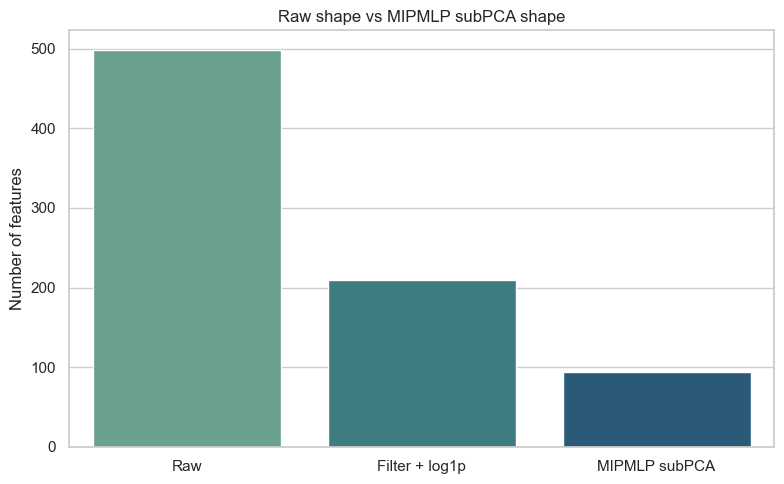

In [28]:
subpca = MIPMLPSubPCA(min_group_size=2)
subpca.fit(X_train_log)

X_train_sub = subpca.transform(X_train_log)
X_test_sub = subpca.transform(X_test_log)

sub_scaler = StandardScaler()
X_train_sub_z = pd.DataFrame(
    sub_scaler.fit_transform(X_train_sub),
    columns=X_train_sub.columns,
    index=X_train_sub.index,
)
X_test_sub_z = pd.DataFrame(
    sub_scaler.transform(X_test_sub),
    columns=X_test_sub.columns,
    index=X_test_sub.index,
)

X_full_sub = subpca.transform(X_full_log)

n_pca_groups = sum(model["mode"] == "pca" for model in subpca.group_models_.values())
n_single_groups = sum(model["mode"] == "single" for model in subpca.group_models_.values())

print(f"Full raw shape: {X_raw.shape}")
print(f"Full shape after filter + log1p: {X_full_log.shape}")
print(f"Full shape after MIPMLP subPCA: {X_full_sub.shape}")
print(f"subPCA groups: {n_pca_groups}")
print(f"single-feature groups: {n_single_groups}")

shape_table_sub = pd.DataFrame(
    [
        {"stage": "Raw", "n_features": X_raw.shape[1]},
        {"stage": "Filter + log1p", "n_features": X_full_log.shape[1]},
        {"stage": "MIPMLP subPCA", "n_features": X_full_sub.shape[1]},
    ]
)

display(shape_table_sub)

plt.figure(figsize=(8, 5))
sns.barplot(data=shape_table_sub, x="stage", y="n_features", palette="crest")
plt.title("Raw shape vs MIPMLP subPCA shape")
plt.xlabel("")
plt.ylabel("Number of features")
plt.tight_layout()
plt.show()


,group,mode,n_original_features,pc1_explained_variance
2,Aeriscardovia,single,1,NaN
3,Agathobaculum,single,1,NaN
4,Akkermansia,single,1,NaN
6,Anaerobutyricum,single,1,NaN
7,Anaerofustis,single,1,NaN
8,Anaeromassilibacillus,single,1,NaN
9,Anaerostipes,single,1,NaN
10,Anaerotruncus,single,1,NaN
12,Barnesiella,single,1,NaN
14,Bilophila,single,1,NaN


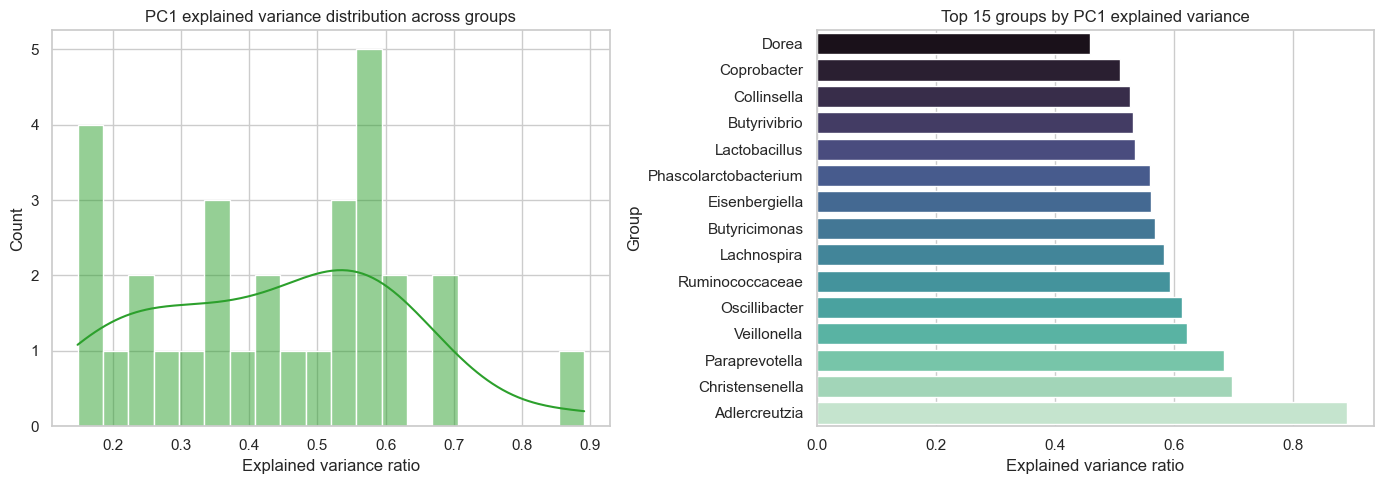

In [29]:
subpca_summary = subpca.summary()
display(subpca_summary.head(20))

ev = pd.Series(subpca.explained_variance_).sort_values(ascending=False)

if len(ev) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(ev, bins=20, kde=True, color="#2ca02c", ax=axes[0])
    axes[0].set_title("PC1 explained variance distribution across groups")
    axes[0].set_xlabel("Explained variance ratio")

    top_ev = ev.head(15).sort_values()
    sns.barplot(x=top_ev.values, y=top_ev.index, palette="mako", ax=axes[1])
    axes[1].set_title("Top 15 groups by PC1 explained variance")
    axes[1].set_xlabel("Explained variance ratio")
    axes[1].set_ylabel("Group")

    plt.tight_layout()
    plt.show()
else:
    print("No multi-feature groups were available for subPCA.")


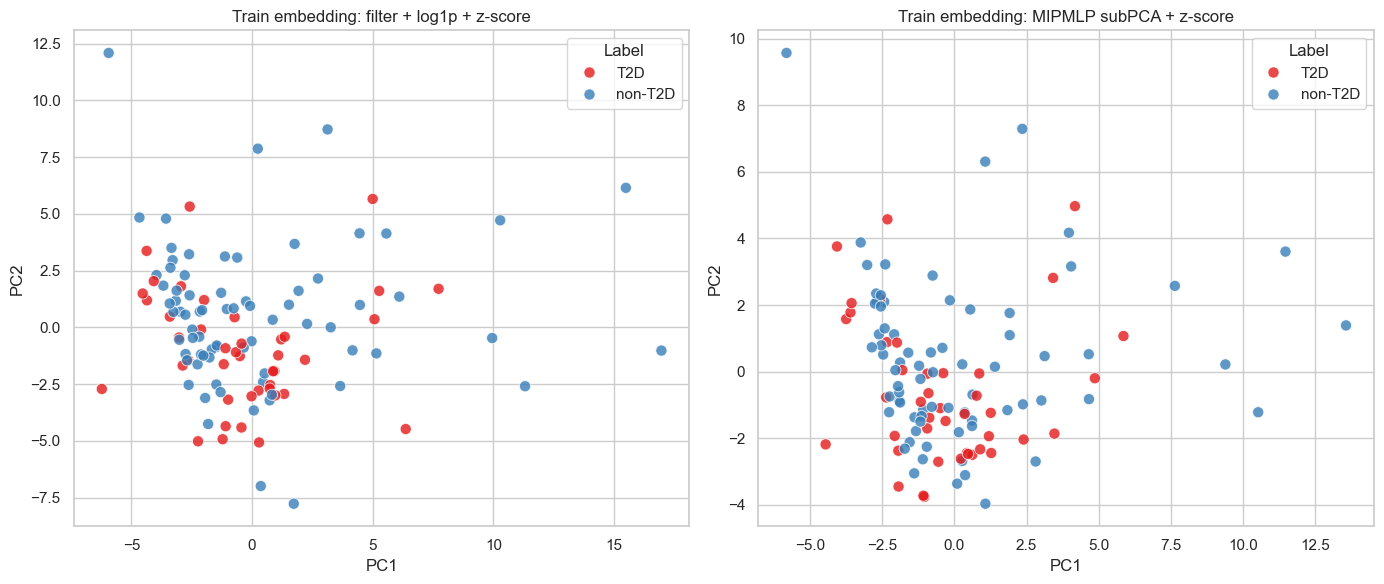

2D PCA variance captured (base): 0.117
2D PCA variance captured (subPCA rep): 0.164


In [30]:
train_label_names = pd.Series(np.where(y_train == 1, "T2D", "non-T2D"), index=y_train.index)

pca_base = PCA(n_components=2, random_state=SEED)
pca_sub = PCA(n_components=2, random_state=SEED)

base_2d = pca_base.fit_transform(X_train_base_z)
sub_2d = pca_sub.fit_transform(X_train_sub_z)

plot_base = pd.DataFrame(base_2d, columns=["PC1", "PC2"], index=y_train.index)
plot_base["label"] = train_label_names.values

plot_sub = pd.DataFrame(sub_2d, columns=["PC1", "PC2"], index=y_train.index)
plot_sub["label"] = train_label_names.values

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=plot_base, x="PC1", y="PC2", hue="label", palette="Set1", s=65, alpha=0.8, ax=axes[0])
axes[0].set_title("Train embedding: filter + log1p + z-score")
axes[0].legend(title="Label")

sns.scatterplot(data=plot_sub, x="PC1", y="PC2", hue="label", palette="Set1", s=65, alpha=0.8, ax=axes[1])
axes[1].set_title("Train embedding: MIPMLP subPCA + z-score")
axes[1].legend(title="Label")

plt.tight_layout()
plt.show()

print(f"2D PCA variance captured (base): {pca_base.explained_variance_ratio_.sum():.3f}")
print(f"2D PCA variance captured (subPCA rep): {pca_sub.explained_variance_ratio_.sum():.3f}")


### How to read the subPCA outputs

- Shape table shows dimensionality reduction from raw taxa to grouped components.
- `subpca_summary` tells which groups were compressed and how informative PC1 is.
- 2D scatter plots are not final model performance, but they help check whether representation improves structure.
